## 1. Preliminary

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import yaml
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")
from utils import load_paper_node, load_paper_edge

## 2. Load and inspect the dataset

In [3]:
# Load config file and get the path of csv files
with open("./config/config.yaml", "r") as file:
    config = yaml.safe_load(file)
PAPER_NODE = Path(config["data"]["paper"]["node"])
PAPER_EDGE = Path(config["data"]["paper"]["edge"])

In [4]:
df_node = load_paper_node(PAPER_NODE, False)

2024-12-10 14:13:12 - SocialNetwork - INFO - Load data\paper\node.csv as dataframe, memory usage 1962.97 MB
2024-12-10 14:13:12 - SocialNetwork - INFO - Function 'load_paper_node' executed in 20.19 second(s)


In [5]:
df_node.head()

,id,title,authors,year,venue,references,out_d,in_d
0,555036b37cea80f954149ffc,Approximate Distance Oracles with Improved Que...,[Christian Wulff-Nilsen],2015,Encyclopedia of Algorithms,<NA>,0,0
1,555036b37cea80f954149ffd,Subset Sum Algorithm for Bin Packing.,[Julián Mestre],2015,Encyclopedia of Algorithms,<NA>,0,0
2,555036b37cea80f954149ffe,Minimum Weighted Completion Time.,"[V. S. Anil Kumar, Madhav V. Marathe, Srinivas...",2015,Encyclopedia of Algorithms,<NA>,0,0
3,555036b37cea80f954149fff,Multiple String Matching.,"[Maxime Crochemore, Thierry Lecroq]",2015,Encyclopedia of Algorithms,<NA>,0,0
4,555036b37cea80f95414a000,Fault-Tolerant Connected Dominating Set.,"[Donghyun Kim, Wei Wang, Weili Wu, Alade O. To...",2015,Encyclopedia of Algorithms,<NA>,0,0


In [6]:
df_no_nan = df_node.dropna()
df_no_nan.head()

,id,title,authors,year,venue,references,out_d,in_d
321825,5736953f6e3b12023e46e080,Seven Steps to Rendezvous with the Casual User.,[E. F. Codd],1974,IFIP Working Conference Data Base Management,"[5736955c6e3b12023e484b89, 5736955d6e3b12023e4...",18,0
321826,5736953f6e3b12023e46e081,Interactive Support for Non-Programmers: The R...,"[E. F. Codd, C. J. Date]",1974,"IBM Research Report, San Jose, California",[5736972c6e3b12023e61e097],1,0
321827,5736953f6e3b12023e46e082,Common Subexpression Identification in General...,[Patrick A. V. Hall],1974,"Technical Rep. UKSC 0060, IBM United Kingdom S...","[5736955d6e3b12023e484d00, 573696856e3b12023e5...",10,0
321829,5736953f6e3b12023e46e084,Principles of Distributed Object Database Lang...,[Markus Tresch],1996,"technical Report 248, ETH Zürich, Dept. of Com...",[5736972c6e3b12023e61df67],1,0
321830,5736953f6e3b12023e46e085,Relational Completeness of Data Base Sublangua...,[E. F. Codd],1972,"In: R. Rustin (ed.): Database Systems: 65-98, ...","[5736955c6e3b12023e484b50, 5736955c6e3b12023e4...",174,0


## 3. Count NaN values

In [7]:
nan_counts = df_node.isna().sum()
print(nan_counts)

id                  0
title               0
authors         52010
year                0
venue           56785
references    1906376
out_d               0
in_d                0
dtype: int64


## 4. Plot the distribution of list columns

In [8]:
# Ensure that NaN values are handled by converting them to empty lists
df_node["authors"] = df_node["authors"].apply(
    lambda x: x if isinstance(x, list) and x != [""] else []
)

# Calculate the number of authors and references for each row
df_node["num_authors"] = df_node["authors"].apply(len)

# Calculate basic statistics
print(df_node["num_authors"].describe())
print("=" * 20)
print(df_node["out_d"].describe())
print("=" * 20)
print(df_node["in_d"].describe())

count    3.680007e+06
mean     2.836479e+00
std      1.748325e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      1.390000e+02
Name: num_authors, dtype: float64
count    3.680007e+06
mean     5.097998e-01
std      1.294739e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      6.090000e+02
Name: out_d, dtype: float64
count    3.680007e+06
mean     5.097998e-01
std      1.059119e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.067000e+03
Name: in_d, dtype: float64


count    3.626640e+06
mean     2.867512e+00
std      1.640951e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      2.000000e+01
Name: num_authors, dtype: float64


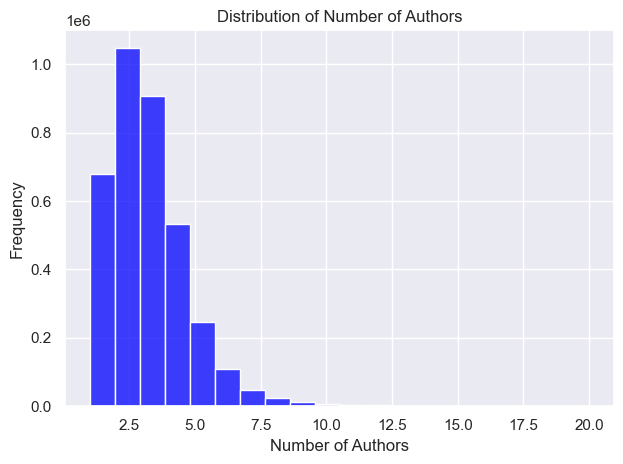

In [9]:
df_filtered_authors = df_node[(df_node['num_authors'] > 0) & (df_node['num_authors'] <= 20)]
print(df_filtered_authors["num_authors"].describe())

# Plot the distribution of the number of authors
sns.histplot(df_filtered_authors['num_authors'], color='blue', bins=20)
plt.title('Distribution of Number of Authors')
plt.xlabel('Number of Authors')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

count    1.773552e+06
mean     1.050111e+00
std      1.073527e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.900000e+01
Name: out_d, dtype: float64


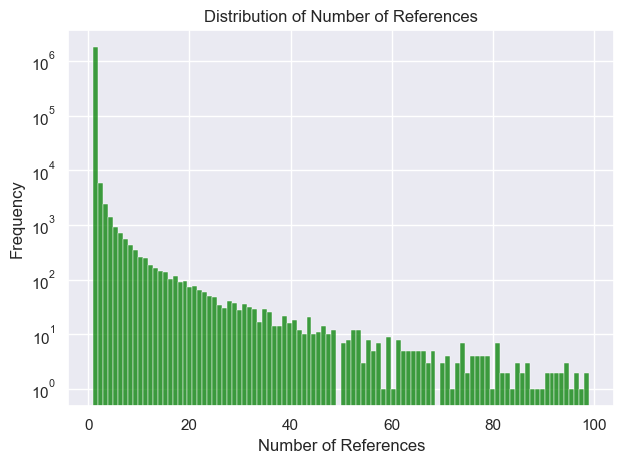

In [10]:
df_filtered_out_d = df_node[(df_node['out_d'] > 0) & (df_node['out_d'] <= 100)]
print(df_filtered_out_d["out_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_out_d['out_d'], color='green', bins=100)
plt.title('Distribution of Number of References')
plt.xlabel('Number of References')
plt.ylabel('Frequency')
plt.yscale("log")
plt.tight_layout()
plt.show()

count    35162.000000
mean        29.818099
std         22.514989
min          1.000000
25%         13.000000
50%         23.000000
75%         41.000000
max        100.000000
Name: in_d, dtype: float64


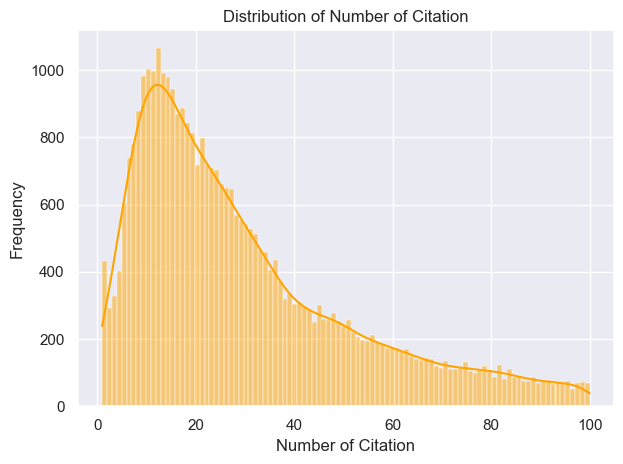

In [14]:
df_filtered_in_d = df_node[(df_node['in_d'] > 0) & (df_node['in_d'] <= 100)]
print(df_filtered_in_d["in_d"].describe())

# Plot the distribution of the number of references
sns.histplot(df_filtered_in_d['in_d'], color='orange', kde=True, bins=100)
plt.title('Distribution of Number of Citation')
plt.xlabel('Number of Citation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 5. Probe other columns

In [12]:
# Get the unique venues and their occurrences
venue_counts = df_node['venue'].value_counts()

# Iterate over the venues and print them with their occurrences
for venue, count in venue_counts.items():
    print(f"{venue}: {count}")


CoRR: 122451
ICASSP: 23336
IEICE Transactions: 19079
ICRA: 18760
Applied Mathematics and Computation: 16282
ICC: 15641
IROS: 15169
GLOBECOM: 14785
IGARSS: 14397
IEEE Trans. Information Theory: 13509
Discrete Mathematics: 13334
INTERSPEECH: 13010
ISCAS: 11801
ICIP: 11642
Theor. Comput. Sci.: 11513
Commun. ACM: 11277
European Journal of Operational Research: 11076
IEEE Trans. Signal Processing: 10649
IACR Cryptology ePrint Archive: 10353
Bioinformatics: 10288
HICSS: 10096
Expert Syst. Appl.: 10021
Neurocomputing: 9896
CDC: 9839
SMC: 9641
EUSIPCO: 9308
Winter Simulation Conference: 9091
IEEE Trans. Communications: 8970
PIMRC: 8864
Automatica: 8748
NeuroImage: 8673
IEEE Trans. Computers: 8637
Sensors: 8598
Inf. Sci.: 8229
WCNC: 8224
BMC Bioinformatics: 8027
Pattern Recognition: 7428
IEEE Trans. Geoscience and Remote Sensing: 7318
IEEE Trans. Industrial Electronics: 7287
INFOCOM: 7277
AMCIS: 7259
Inf. Process. Lett.: 7180
IJCAI: 7020
AMIA: 6929
Discrete Applied Mathematics: 6816
DAC: 6715
V

In [13]:
# Get the unique venues and their occurrences
year_counts = df_node['year'].value_counts()

# Iterate over the venues and print them with their occurrences
# NOTE: 0 incidates the value of year is missing
for year, count in year_counts.items():
    print(f"{year}: {count}")

2015: 266301
2014: 261410
2013: 253516
2016: 252751
2012: 241871
2011: 231089
2010: 213360
2009: 206704
2008: 190334
2007: 175959
2006: 160608
2005: 146117
2004: 124160
2003: 103892
2002: 87105
2001: 77169
2000: 72040
1999: 63116
1998: 56317
1997: 51473
1996: 46686
1995: 42515
1994: 40581
1993: 35803
1992: 29907
1991: 26381
2017: 25938
1990: 23055
1989: 20342
1988: 17669
1987: 15138
1986: 14133
1985: 11585
1984: 11136
1983: 9573
1982: 8601
1981: 7463
1980: 6741
1979: 5798
1978: 5212
1977: 5114
1976: 4495
1975: 4016
1974: 3812
1973: 3274
1972: 2913
1971: 2459
1968: 1872
1970: 1825
1969: 1669
1967: 1456
1966: 1129
1965: 966
1962: 944
1964: 805
1963: 803
1961: 628
1959: 461
1960: 434
1958: 258
1957: 232
1956: 195
1954: 157
1955: 145
1953: 114
1952: 34
1946: 31
1950: 26
1949: 25
1951: 19
1939: 18
1948: 16
1937: 15
1941: 13
1942: 13
1936: 12
1938: 11
1947: 10
1940: 10
1945: 9
1943: 8
0: 7
1944: 5


## 6. Visualize the edges

2024-12-10 14:25:55 - SocialNetwork - INFO - Load data\paper\edge.csv as dataframe, memory usage 289.84 MB
2024-12-10 14:25:55 - SocialNetwork - INFO - Function 'load_paper_edge' executed in 1.74 second(s)


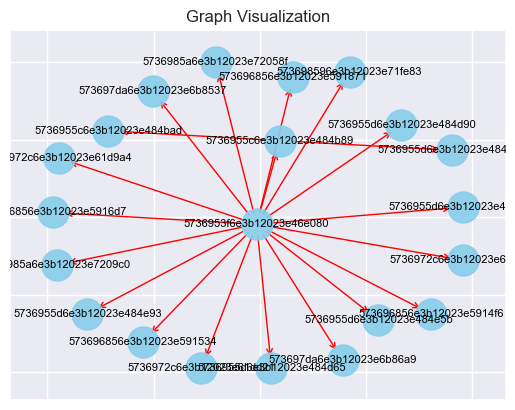

In [21]:
df_edge = load_paper_edge(PAPER_EDGE)
# Create a graph using NetworkX
G = nx.from_pandas_edgelist(df_edge, source='src', target='dst', create_using=nx.DiGraph())

# Get a subset of edges
subgraph_edges = list(G.edges())[:20] 
subgraph = G.edge_subgraph(subgraph_edges)
pos = nx.spring_layout(subgraph)

# Plot the graph
nx.draw_networkx_nodes(subgraph, pos, node_size=500, node_color="skyblue", alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, edge_color="red", arrows=True, arrowsize=10, arrowstyle='->')
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_color="black")
plt.title("Graph Visualization")
plt.show()